# Linear Regression: Demo

In [3]:
# Start with importing the usual stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 

pd.options.mode.copy_on_write = True

In [1]:
# This contains some functions written by the authors of the textbook (ISLP)
# we'll be adapting most of the this demo from their material

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

## Set up data

In [4]:
# First we'll read in our data and look quickly at its contents

#Auto = pd.read_csv('../../data/Auto.csv')
Auto = pd.read_csv('../data/Auto.csv')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [5]:
# Sometimes it's helpful to look at the list of columns
Auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [6]:
# What is the data type of each column?
Auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

## Review the target variable

In [7]:
# Since we want to predict mpg, let's start by listing all its possible values
np.unique(Auto['mpg'])

array([ 9. , 10. , 11. , 12. , 13. , 14. , 14.5, 15. , 15.5, 16. , 16.2,
       16.5, 16.9, 17. , 17.5, 17.6, 17.7, 18. , 18.1, 18.2, 18.5, 18.6,
       19. , 19.1, 19.2, 19.4, 19.8, 19.9, 20. , 20.2, 20.3, 20.5, 20.6,
       20.8, 21. , 21.1, 21.5, 21.6, 22. , 22.3, 22.4, 22.5, 23. , 23.2,
       23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.2, 24.3, 24.5, 25. , 25.1,
       25.4, 25.5, 25.8, 26. , 26.4, 26.5, 26.6, 26.8, 27. , 27.2, 27.4,
       27.5, 27.9, 28. , 28.1, 28.4, 28.8, 29. , 29.5, 29.8, 29.9, 30. ,
       30.5, 30.7, 30.9, 31. , 31.3, 31.5, 31.6, 31.8, 31.9, 32. , 32.1,
       32.2, 32.3, 32.4, 32.7, 32.8, 32.9, 33. , 33.5, 33.7, 33.8, 34. ,
       34.1, 34.2, 34.3, 34.4, 34.5, 34.7, 35. , 35.1, 35.7, 36. , 36.1,
       36.4, 37. , 37.2, 37.3, 37.7, 38. , 38.1, 39. , 39.1, 39.4, 40.8,
       40.9, 41.5, 43.1, 43.4, 44. , 44.3, 44.6, 46.6])

In [8]:
# Are there any missing values in there?
# isnull() returns 1s for each NaN, then we can add them up to get the total count of missing values

Auto['mpg'].isnull().sum()

# CAUTION: This isn't foolproof! It won't find missing values that have been coded as 0, -1, 9999, etc.

np.int64(0)

In [9]:
# Let's create a function that allows us to display a histogram for a variable
# Credit to Hastie and Tibshirani--see their notes for more details on this

def histogram(var):
    n, bins, patches = plt.hist(x=var, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Frequency of ' + var.name)

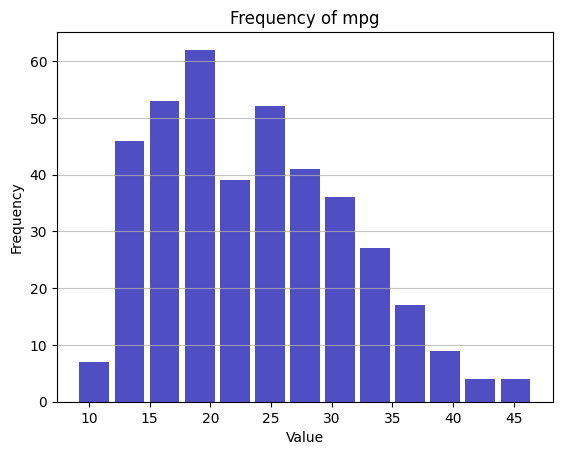

In [10]:
histogram(Auto['mpg'])

## Feature Engineering

### Missing Values

In [11]:
np.unique(Auto['horsepower'])

array(['100', '102', '103', '105', '107', '108', '110', '112', '113',
       '115', '116', '120', '122', '125', '129', '130', '132', '133',
       '135', '137', '138', '139', '140', '142', '145', '148', '149',
       '150', '152', '153', '155', '158', '160', '165', '167', '170',
       '175', '180', '190', '193', '198', '200', '208', '210', '215',
       '220', '225', '230', '46', '48', '49', '52', '53', '54', '58',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70',
       '71', '72', '74', '75', '76', '77', '78', '79', '80', '81', '82',
       '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93',
       '94', '95', '96', '97', '98', '?'], dtype=object)

In [12]:
Auto[(Auto['horsepower']=='?')]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i


In [ ]:
# Should we remove those records?
# Auto = Auto[(Auto['horsepower']!='?')]

In [13]:
# Or should we impute the mean value?

# Ok let's calculate the mean value first
int(pd.to_numeric(Auto['horsepower'], errors='coerce').mean())

104

In [14]:
# Now we'll impute the mean into the missing cells
Auto.replace({'horsepower':'?'},'104',inplace=True)

np.unique(Auto['horsepower'])

array(['100', '102', '103', '104', '105', '107', '108', '110', '112',
       '113', '115', '116', '120', '122', '125', '129', '130', '132',
       '133', '135', '137', '138', '139', '140', '142', '145', '148',
       '149', '150', '152', '153', '155', '158', '160', '165', '167',
       '170', '175', '180', '190', '193', '198', '200', '208', '210',
       '215', '220', '225', '230', '46', '48', '49', '52', '53', '54',
       '58', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69',
       '70', '71', '72', '74', '75', '76', '77', '78', '79', '80', '81',
       '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92',
       '93', '94', '95', '96', '97', '98'], dtype=object)

In [15]:
# Convert the horsepower column to numeric

Auto['horsepower'] = pd.to_numeric(Auto['horsepower'])

## Set up structure for modeling

In [16]:
# Identify some predictors and the target

X = Auto[['horsepower', 'weight', 'year']]
y = Auto['mpg']

In [17]:
# Create a column for the intercept in the features matrix

X['intercept'] = np.ones(Auto.shape[0])
X

,horsepower,weight,year,intercept
0,130,3504,70,1.0
1,165,3693,70,1.0
2,150,3436,70,1.0
3,150,3433,70,1.0
4,140,3449,70,1.0
...,...,...,...,...
392,86,2790,82,1.0
393,52,2130,82,1.0
394,84,2295,82,1.0
395,79,2625,82,1.0


In [ ]:
# Create training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 
Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

In [19]:
# Spot check the train and test sets

print(X_train.head()) 
print(X_train.shape)
print()
print(y_train.head()) 
print(y_train.shape)
print() 
print(X_test.head()) 
print(X_test.shape)
print() 
print(y_test.head())
print(y_test.shape)
print() 
print(Train.head())
print(Train.shape)
print() 
print(Test.head())
print(Test.shape)

     horsepower  weight  year  intercept
50           90    2123    71        1.0
69          160    4456    72        1.0
188         150    4190    76        1.0
204          70    1990    76        1.0
28          193    4732    70        1.0
(297, 4)

50     28.0
69     12.0
188    16.0
204    32.0
28      9.0
Name: mpg, dtype: float64
(297,)

     horsepower  weight  year  intercept
118          75    2158    73        1.0
273          97    2405    78        1.0
356          75    2350    81        1.0
2           150    3436    70        1.0
35          100    3329    71        1.0
(100, 4)

118    24.0
273    23.9
356    32.4
2      18.0
35     17.0
Name: mpg, dtype: float64
(100,)

   horsepower  weight  year  intercept   mpg
0         130    3504    70        1.0  18.0
1         150    3433    70        1.0  16.0
2         140    3449    70        1.0  17.0
3         198    4341    70        1.0  15.0
4         220    4354    70        1.0  14.0
(297, 5)

   horsepower  weigh

In [20]:
# Look at possible values and spot check for missing entries

print('MPG')
print(np.unique(Train['mpg']))
print('Horsepower')
print(np.unique(Train['horsepower']))
print('Weight')
print(np.unique(Train['weight']))
print('Year')
print(np.unique(Train['year']))

MPG
[ 9.  10.  11.  12.  13.  14.  14.5 15.  15.5 16.  16.5 17.  17.5 17.6
 17.7 18.  18.1 18.2 18.5 19.  19.1 19.2 19.4 20.  20.2 20.3 20.5 20.6
 20.8 21.  21.1 21.5 22.  22.3 22.4 22.5 23.  23.5 23.7 23.8 23.9 24.
 24.2 24.3 24.5 25.  25.4 25.5 25.8 26.  26.4 26.6 27.  27.2 28.  28.1
 28.4 28.8 29.  29.5 29.8 30.  30.5 30.7 30.9 31.  31.3 31.5 31.6 31.9
 32.  32.1 32.2 32.3 32.4 32.7 32.8 32.9 33.  33.5 33.7 33.8 34.  34.1
 34.2 34.3 34.4 34.5 35.  35.1 35.7 36.  36.4 37.  37.2 37.3 37.7 38.
 38.1 39.  40.8 43.1 43.4 44.  44.3 44.6 46.6]
Horsepower
[ 46  48  52  53  60  61  62  63  64  65  67  68  69  70  71  72  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  90  92  93  94  95
  96  97  98 100 102 103 104 105 107 108 110 112 113 115 116 120 122 125
 129 130 132 135 137 138 139 140 145 149 150 152 155 158 160 165 167 170
 175 180 190 193 198 200 210 215 220 225 230]
Weight
[1613 1649 1760 1795 1825 1834 1835 1845 1850 1875 1915 1925 1937 1940
 1945 1950 1955 1963 1965 1

## Simple Linear Regression, Example 1

In [21]:
# Build a linear model where horsepower predicts mpg
# Take note of the p-values

model_hp = sm.OLS(y_train, X_train[['intercept','horsepower']])
results_hp = model_hp.fit()
summarize(results_hp)

,coef,std err,t,P>|t|
intercept,40.0071,0.843,47.441,0.0
horsepower,-0.1565,0.008,-20.607,0.0


In [22]:
# We can also assess the overall fit of the model

print('R^2 on train:',results_hp.rsquared)

R^2 on train: 0.5900747201732627


In [23]:
# Create helper functions for computing the mean squared error

def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

In [24]:
# Let's compute the MSE on the training and test sets

predictions_hp_train = predict(X_train[['intercept', 'horsepower']], results_hp)
print('mse train:',mse(y_train, predictions_hp_train))
predictions_hp_test = predict(X_test[['intercept', 'horsepower']], results_hp)
print('mse test:',mse(y_test, predictions_hp_test))

mse train: 25.503857097648705
mse test: 22.502455766751464


In [25]:
# Define a function to draw a line given coefficients [credit to Hastie & Tibshirani]

def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

C:\Users\kate\AppData\Local\Temp\ipykernel_28412\4284870531.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_hp.params[0],
C:\Users\kate\AppData\Local\Temp\ipykernel_28412\4284870531.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_hp.params[1],


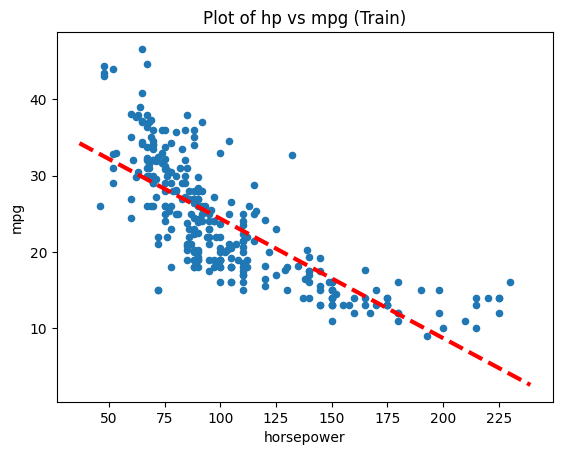

In [26]:
# Plot hp vs mpg on training set

ax = Train.plot.scatter('horsepower', 'mpg')
ax.set_title("Plot of hp vs mpg (Train)")
abline(ax,
       results_hp.params[0],
       results_hp.params[1],
       'r--',
       linewidth=3)

C:\Users\kate\AppData\Local\Temp\ipykernel_28412\1539759288.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_hp.params[0],
C:\Users\kate\AppData\Local\Temp\ipykernel_28412\1539759288.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_hp.params[1],


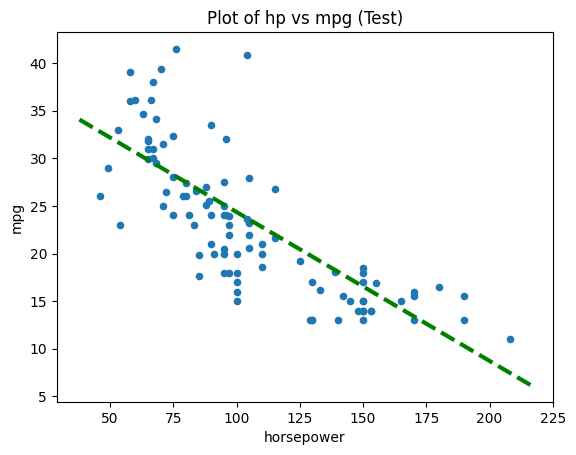

In [27]:
# Plot hp vs mpg on test set

ax = Test.plot.scatter('horsepower', 'mpg')
ax.set_title("Plot of hp vs mpg (Test)")
abline(ax,
       results_hp.params[0],
       results_hp.params[1],
       'g--',
       linewidth=3)

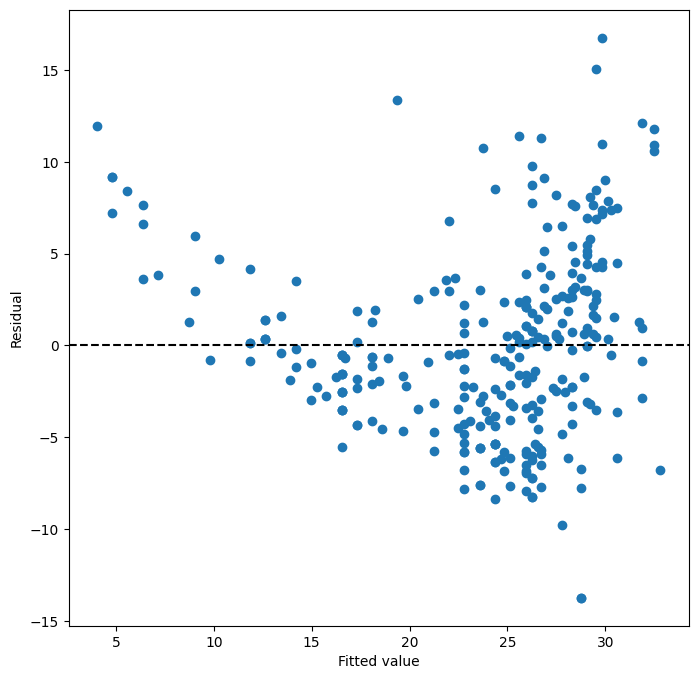

In [28]:
# Plot residual error for train set

ax = subplots(figsize=(8,8))[1]
ax.scatter(predictions_hp_train, y_train-predictions_hp_train)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

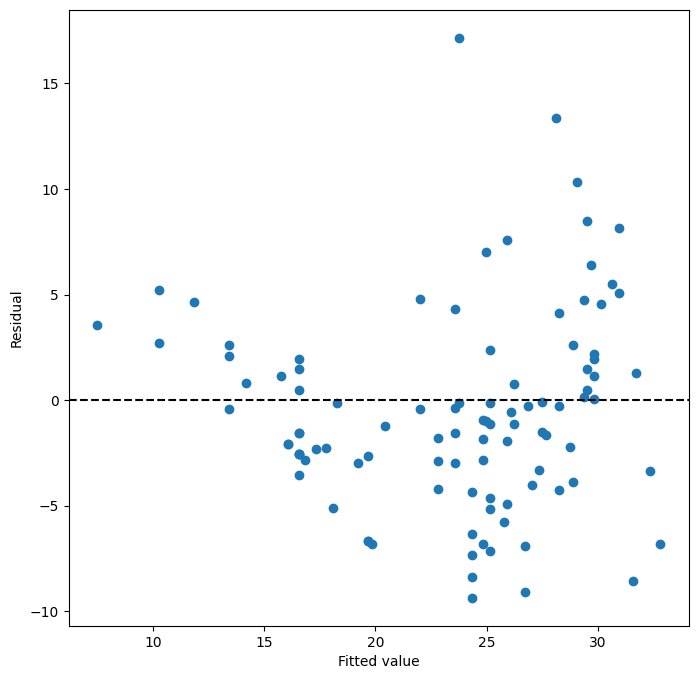

In [29]:
# Plot residual error for test set

ax = subplots(figsize=(8,8))[1]
ax.scatter(predictions_hp_test, y_test-predictions_hp_test)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

## Simple Linear Regression, Example 2

In [30]:
# Build a linear model where weight predicts mpg

model_weight = sm.OLS(y_train, X_train[['intercept','weight']])
results_weight = model_weight.fit()
summarize(results_weight)

,coef,std err,t,P>|t|
intercept,46.3031,0.958,48.337,0.0
weight,-0.0077,0.000,-24.521,0.0


In [31]:
# R^2 for weight model
print('R^2 on train:',results_weight.rsquared)

R^2 on train: 0.6708603203400083


In [32]:
# MSE for weight model

predictions_weight_train = predict(X_train[['intercept', 'weight']], results_weight)
print('mse train:',mse(y_train, predictions_weight_train))
predictions_weight_test = predict(X_test[['intercept', 'weight']], results_weight)
print('mse test:',mse(y_test, predictions_weight_test))

mse train: 20.47771086175101
mse test: 13.936296494496167


C:\Users\kate\AppData\Local\Temp\ipykernel_28412\3058333323.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_weight.params[0],
C:\Users\kate\AppData\Local\Temp\ipykernel_28412\3058333323.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_weight.params[1],


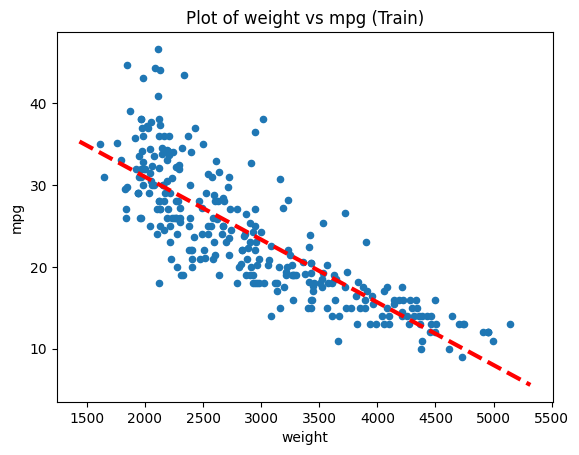

In [33]:
# Plot weight vs mpg on training set

ax = Train.plot.scatter('weight', 'mpg')
ax.set_title("Plot of weight vs mpg (Train)")
abline(ax,
       results_weight.params[0],
       results_weight.params[1],
       'r--',
       linewidth=3)

C:\Users\kate\AppData\Local\Temp\ipykernel_28412\2628305924.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_weight.params[0],
C:\Users\kate\AppData\Local\Temp\ipykernel_28412\2628305924.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_weight.params[1],


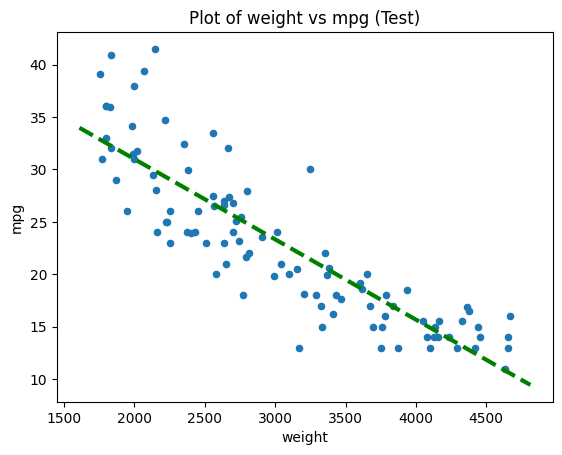

In [34]:
# Plot weight vs mpg on test set

ax = Test.plot.scatter('weight', 'mpg')
ax.set_title("Plot of weight vs mpg (Test)")
abline(ax,
       results_weight.params[0],
       results_weight.params[1],
       'g--',
       linewidth=3)

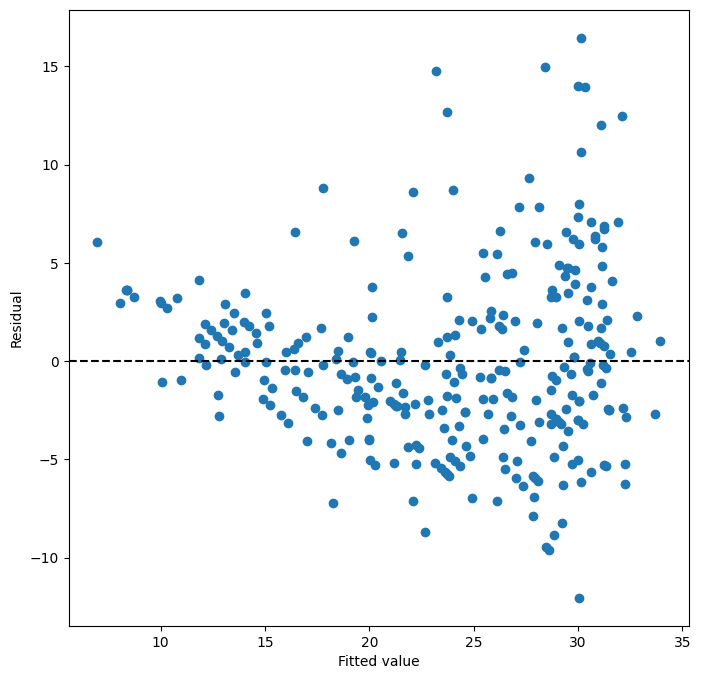

In [35]:
# Plot residual error for training set

ax = subplots(figsize=(8,8))[1]
ax.scatter(predictions_weight_train, y_train-predictions_weight_train)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

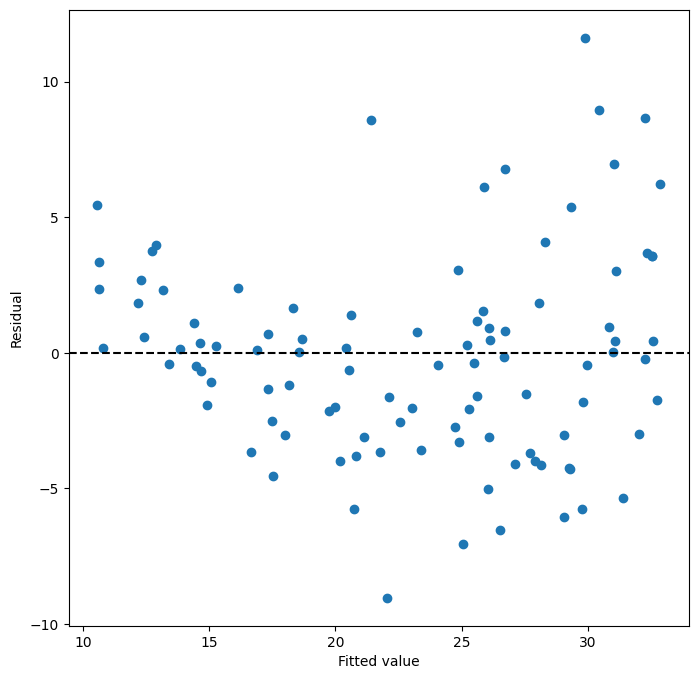

In [36]:
# Plot residual error for test set

ax = subplots(figsize=(8,8))[1]
ax.scatter(predictions_weight_test, y_test-predictions_weight_test)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

## Simple Linear Regression, Example 3

In [37]:
# Build a linear model where year predicts mpg
model_year = sm.OLS(y_train, X_train[['intercept','year']])
results_year = model_year.fit()
summarize(results_year)


,coef,std err,t,P>|t|
intercept,-72.2504,7.365,-9.809,0.0
year,1.2624,0.097,13.046,0.0


In [38]:
# Compute the R^2 for year model (on train)
print('R^2 on train:',results_year.rsquared)


R^2 on train: 0.3658610608015044


In [39]:
# Compute the MSE for year model (on train and then on test)
predictions_year_train = predict(X_train[['intercept', 'year']], results_year)
print('mse train:',mse(y_train, predictions_year_train))
predictions_year_test = predict(X_test[['intercept', 'year']], results_year)
print('mse test:',mse(y_test, predictions_year_test))


mse train: 39.45350453187175
mse test: 43.511242976481014


C:\Users\kate\AppData\Local\Temp\ipykernel_28412\1093765752.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_year.params[0],
C:\Users\kate\AppData\Local\Temp\ipykernel_28412\1093765752.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_year.params[1],


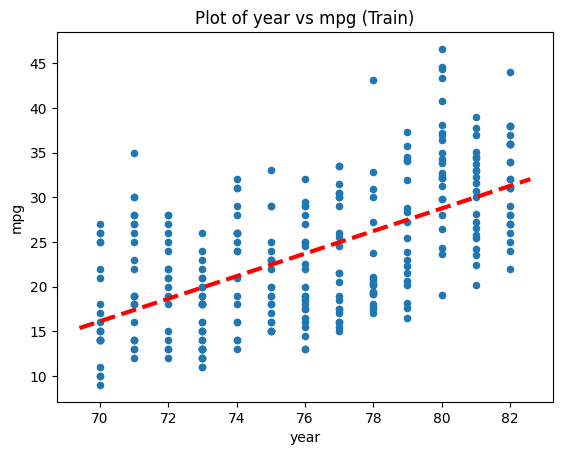

In [41]:
# Plot year vs mpg (on train)
ax = Train.plot.scatter('year', 'mpg')
ax.set_title("Plot of year vs mpg (Train)")
abline(ax,
       results_year.params[0],
       results_year.params[1],
       'r--',
       linewidth=3)


C:\Users\kate\AppData\Local\Temp\ipykernel_28412\2598130675.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_year.params[0],
C:\Users\kate\AppData\Local\Temp\ipykernel_28412\2598130675.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_year.params[1],


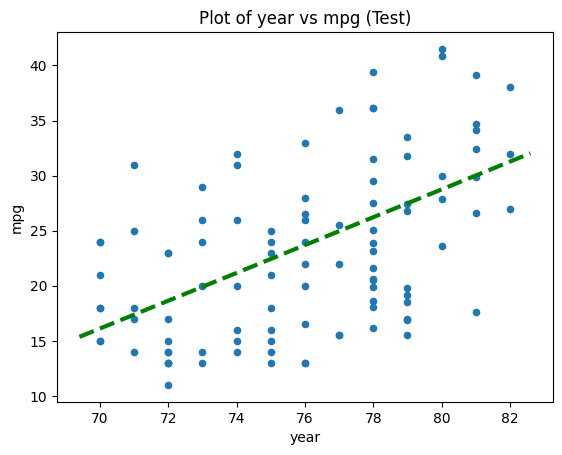

In [42]:
# Plot year vs mpg (on test)
ax = Test.plot.scatter('year', 'mpg')
ax.set_title("Plot of year vs mpg (Test)")
abline(ax,
       results_year.params[0],
       results_year.params[1],
       'g--',
       linewidth=3)

## Categorical Predictors

In [43]:
# One potentially useful variable is the name of the vehicle

Auto['name']

0      chevrolet chevelle malibu
1              buick skylark 320
2             plymouth satellite
3                  amc rebel sst
4                    ford torino
                 ...            
392              ford mustang gl
393                    vw pickup
394                dodge rampage
395                  ford ranger
396                   chevy s-10
Name: name, Length: 397, dtype: object

In [44]:
# Let's grab just the first word in each vehicle name, which appears to be the "make"

Auto['make'] = Auto['name'].str.split(' ').str[0]

In [45]:
# Take a look at the possible values

Auto['make'].value_counts()

make
ford             51
chevrolet        43
plymouth         31
dodge            28
amc              27
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
oldsmobile       10
mazda            10
peugeot           8
fiat              8
audi              7
vw                6
volvo             6
chrysler          6
renault           5
saab              4
subaru            4
opel              4
chevy             3
cadillac          2
bmw               2
mercedes-benz     2
maxda             2
hi                1
toyouta           1
chevroelt         1
capri             1
mercedes          1
vokswagen         1
triumph           1
nissan            1
Name: count, dtype: int64

In [ ]:
# What cleaning should be done?








In [ ]:
# If we want to include this variable in our model, we might want to do one hot encoding

one_hot = pd.get_dummies(Auto, columns = ['make']) 
one_hot

## Simple (or Multiple?) Linear Regression, Example 4

In [ ]:
# Build a linear model where 'make_toyota', 'make_ford', and 'make_pontiac' predict mpg



In [ ]:
# Compute the R^2 for this model (on train)



In [ ]:
# Compute the MSE for this model (on train and then on test)

